In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from statsmodels.stats.anova import AnovaRM
plt.style.use('figure.mplstyle')

from function.data2p import get_data_bis

In [2]:
# %% Setup
folder = r'D:\LW_Alldata\SI_Transient'
alldata = {'Enriched': glob(os.path.join(folder,'Enriched*.hdf5')),
           'Dissimilar': glob(os.path.join(folder,'Distinct*.hdf5')),
           'Similar': [os.path.join(folder,'Similar5_937_invivo.hdf5'),
                       os.path.join(folder,'Similar6_939_invivo.hdf5'),
                       os.path.join(folder,'Similar7_948_invivo.hdf5'),
                       os.path.join(folder,'Similar8_5454_invivo.hdf5')]}
excelfile = r'C:\Users\Hung-Ling\Desktop\MC_Results\New Results\Context decoder day.xlsx'
exps = ['Enriched','Dissimilar','Similar']
colors = ['tab:red','tab:blue','tab:green']

In [3]:
# %% Load data
df_list = []
for p, exp in enumerate(exps):
    df = pd.read_excel(excelfile, sheet_name=exp)
    df['Experiment'] = np.repeat(exp, df.shape[0])
    df_list.append(df)
    
df = pd.concat(df_list, ignore_index=True)
print(df)

    Accuracy  Day  Mouse  Experiment
0   1.000000    1      0    Enriched
1   0.950000    2      0    Enriched
2   0.916667    3      0    Enriched
3   0.866667    1      1    Enriched
4   0.753846    2      1    Enriched
5   0.850000    3      1    Enriched
6   0.975000    1      2    Enriched
7   1.000000    2      2    Enriched
8   0.925000    3      2    Enriched
9   0.925000    1      3    Enriched
10  0.950000    2      3    Enriched
11  0.900000    3      3    Enriched
12  0.833333    1      0  Dissimilar
13  0.900000    2      0  Dissimilar
14  0.900000    3      0  Dissimilar
15  0.950000    1      1  Dissimilar
16  1.000000    2      1  Dissimilar
17  0.966667    3      1  Dissimilar
18  0.933333    1      2  Dissimilar
19  0.950000    2      2  Dissimilar
20  0.866667    3      2  Dissimilar
21  0.475000    1      0     Similar
22  0.550000    2      0     Similar
23  0.800000    3      0     Similar
24  0.775000    1      1     Similar
25  0.775000    2      1     Similar
2

In [5]:
for p, exp in enumerate(exps):
    print('-'*25 + exp + '-'*25)
    res = pg.rm_anova(data=df_list[p], dv='Accuracy', subject='Mouse', within='Day')
    print(res)

-------------------------Enriched-------------------------
  Source  ddof1  ddof2         F     p-unc       ng2       eps
0    Day      2      6  1.057082  0.404317  0.073726  0.615876
-------------------------Dissimilar-------------------------
  Source  ddof1  ddof2     F     p-unc       ng2     eps
0    Day      2      4  1.52  0.322831  0.162393  0.5004
-------------------------Similar-------------------------
  Source  ddof1  ddof2         F     p-unc       ng2       eps
0    Day      2      6  0.298932  0.752044  0.051153  0.584511


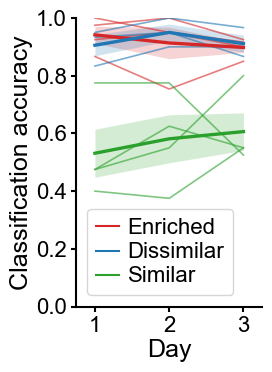

In [8]:
# %% Plot
nday = len(set(df['Day']))
fig, ax = plt.subplots(figsize=(3,4))
for p, exp in enumerate(exps):
    A = df[df['Experiment']==exp]
    n_mice = len(set(A['Mouse']))
    for m in range(n_mice):
        a = A[A['Mouse']==m]['Accuracy']
        ax.plot(np.arange(1,nday+1), a, c=colors[p], alpha=0.6, lw=1.2)
sns.lineplot(df, x='Day', y='Accuracy', hue='Experiment', palette=colors, lw=2.4,
             errorbar='se', err_style='band',  # err_style=bars', 
             err_kws=dict(lw=0))  # err_kws=dict(elinewidth=2, capthick=2, capsize=4)
ax.set(xlim=[0.75,3.25], ylim=[0,1], ylabel='Classification accuracy')
ax.legend(loc='best')
fig.tight_layout()
fig.savefig('Decode context day.svg')

## Stability (activity difference)

In [9]:
day = [1,2,3]  # Recording days, None for all days
min_rate = 1/60  # Minimum transient rate for active cells
nday = len(day)
dauc_list = []

for p, exp in enumerate(exps):

    datapaths = alldata[exp]
    dauc = []
    for m, datapath in enumerate(datapaths):
        data, cells, days, ctx, _ = get_data_bis(datapath, day=day, min_rate=min_rate)
        auc = 60*cells['trate'].T  # (2*nday, ncell)
        dauc.append(np.vstack([auc[2*d+1]-auc[2*d] for d in range(nday)]))  # (nday, ncell) Nov-Fam
        # dauc.append(np.vstack([(auc[2*d+1]-auc[2*d])/(auc[2*d+1]+auc[2*d]) for d in range(nday)]))
    dauc = np.hstack(dauc)    
    dauc = dauc[:,np.all(np.isfinite(dauc),axis=0)]
    dauc_list.append(dauc)
    
    print('-'*16 + exp + '-'*16)
    print('Day1-2 correlation r=%.4g p=%.4g' % stats.pearsonr(dauc[0], dauc[1]))
    print('Day2-3 correlation r=%.4g p=%.4g' % stats.pearsonr(dauc[1], dauc[2]))

----------------Enriched----------------
Day1-2 correlation r=0.211 p=0.0008467
Day2-3 correlation r=0.3298 p=1.123e-07
----------------Dissimilar----------------
Day1-2 correlation r=0.3792 p=6.108e-05
Day2-3 correlation r=0.4717 p=3.33e-07
----------------Similar----------------
Day1-2 correlation r=0.1303 p=0.06315
Day2-3 correlation r=-0.1236 p=0.07818


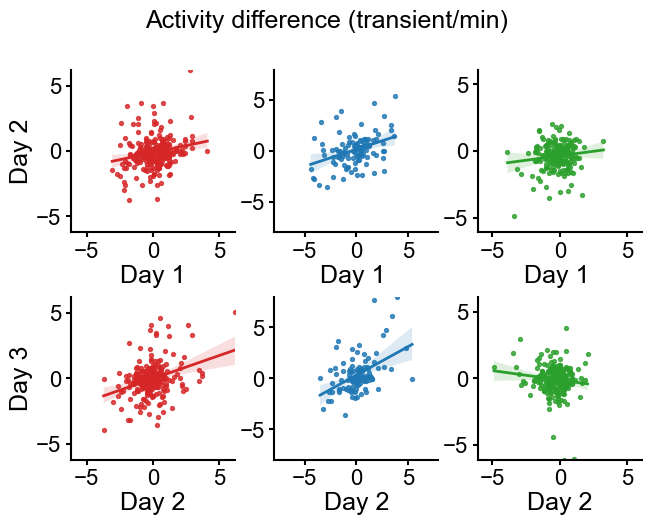

In [11]:
fig, axs = plt.subplots(2,3,figsize=(6.8,5.4))
fig.suptitle('Activity difference (transient/min)')
for p, dauc in enumerate(dauc_list):
    rmax = np.max(np.abs(dauc))
    df12 = pd.DataFrame(dauc[0:2].T, columns=['D1','D2'])
    sns.regplot(df12, x='D1', y='D2', ax=axs[0,p], color=colors[p], scatter_kws=dict(s=8), line_kws=dict(lw=2))
    df23 = pd.DataFrame(dauc[1:3].T, columns=['D2','D3'])
    sns.regplot(df23, x='D2', y='D3', ax=axs[1,p], color=colors[p], scatter_kws=dict(s=8), line_kws=dict(lw=2))
    axs[0,p].set(xlim=[-rmax,rmax], ylim=[-rmax,rmax])
    axs[1,p].set(xlim=[-rmax,rmax], ylim=[-rmax,rmax])
for ax in axs.ravel():
    ax.set(xlabel='', ylabel='')
axs[0,0].set(xlabel='Day 1', ylabel='Day 2')
axs[0,1].set(xlabel='Day 1 ')
axs[0,2].set(xlabel='Day 1 ')
axs[1,0].set(xlabel='Day 2', ylabel='Day 3')
axs[1,1].set(xlabel='Day 2')
axs[1,2].set(xlabel='Day 2')
fig.tight_layout()
fig.subplots_adjust(hspace=0.4, wspace=0.24)
fig.savefig('Stability context.svg')